# MLOps: Experiment Tracking & Model Management

This notebook demonstrates MLOps best practices:
- MLflow experiment tracking
- Model registry and versioning
- A/B testing framework
- Model comparison and selection

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Add src to path
sys.path.insert(0, str(Path("../src").resolve()))

from fittrack.data.ingestion import HARDataLoader, ACTIVITY_LABELS
from fittrack.data.preprocessing import create_train_val_test_split
from fittrack.models.classical import train_random_forest, train_xgboost, ModelConfig
from fittrack.models.evaluation import compute_metrics
from fittrack.mlops.tracking import (
    ExperimentTracker,
    log_training_run,
    setup_mlflow,
    start_run,
)
from fittrack.mlops.registry import ModelRegistry, promote_best_to_production
from fittrack.mlops.ab_testing import (
    ABTest,
    run_offline_ab_test,
    compute_sample_size,
)

import mlflow

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

# Determine project root (works whether run from notebooks/ or fittrack-ml/)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
FIGURES_DIR = PROJECT_ROOT / "docs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Set MLflow tracking URI (local directory)
MLFLOW_DIR = Path("../mlruns")
MLFLOW_DIR.mkdir(exist_ok=True)
mlflow.set_tracking_uri(str(MLFLOW_DIR))
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


MLflow tracking URI: ../mlruns


## 1. Load Data

In [2]:
# Load and preprocess data
loader = HARDataLoader()
train_data, test_data = loader.load_all()

split = create_train_val_test_split(
    train_data.X,
    train_data.y,
    val_size=0.15,
    test_size=0.15,
    normalize=True,
)

X_test = split.scaler.transform(test_data.X.values)
y_test = split.label_encoder.transform(test_data.y["activity"])

class_names = split.class_names
print(f"Train: {len(split.X_train)}, Val: {len(split.X_val)}, Test: {len(X_test)}")

Train: 5146, Val: 1103, Test: 2947


## 2. MLflow Experiment Tracking

Track experiments with parameters, metrics, and artifacts.

In [3]:
# Initialize experiment tracker
tracker = ExperimentTracker(experiment_name="har-classification")
print(f"Experiment ID: {tracker.experiment_id}")

Experiment ID: 437117228180688625


/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


In [4]:
# Train and log Random Forest
with tracker.start_run(run_name="random-forest-baseline", tags={"model_type": "random_forest"}) as run:
    # Parameters
    rf_params = {
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "class_weight": "balanced",
    }
    tracker.log_params(rf_params)
    
    # Train model
    rf_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
    rf_model.fit(split.X_train, split.y_train)
    
    # Evaluate
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)
    metrics = compute_metrics(y_test, y_pred, y_proba, class_names)
    
    # Log metrics
    tracker.log_metrics(metrics.to_dict())
    
    # Log model
    tracker.log_model(rf_model, "sklearn", registered_model_name="har-classifier")
    
    print(f"Run ID: {run.info.run_id}")
    print(f"Accuracy: {metrics.accuracy:.4f}")
    print(f"F1 Score: {metrics.f1_macro:.4f}")

2026/02/04 20:59:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 783ef7de72f34034a3c8ff3735490248
Accuracy: 0.9257
F1 Score: 0.9235


/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/mlflow/tracking/_model_registry/utils.py:216: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri)
Successfully registered model 'har-classifier'.
Created version '1' of model 'har-classifier'.


In [5]:
# Train and log XGBoost
with tracker.start_run(run_name="xgboost-baseline", tags={"model_type": "xgboost"}) as run:
    from xgboost import XGBClassifier
    
    # Parameters
    xgb_params = {
        "n_estimators": 100,
        "max_depth": 6,
        "learning_rate": 0.1,
        "subsample": 0.8,
    }
    tracker.log_params(xgb_params)
    
    # Train model
    xgb_model = XGBClassifier(
        **xgb_params,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="mlogloss",
    )
    xgb_model.fit(split.X_train, split.y_train)
    
    # Evaluate
    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)
    metrics = compute_metrics(y_test, y_pred, y_proba, class_names)
    
    # Log metrics
    tracker.log_metrics(metrics.to_dict())
    
    # Log model
    tracker.log_model(xgb_model, "xgboost", registered_model_name="har-classifier")
    
    print(f"Run ID: {run.info.run_id}")
    print(f"Accuracy: {metrics.accuracy:.4f}")
    print(f"F1 Score: {metrics.f1_macro:.4f}")

/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026/02/04 20:59:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Run ID: adc7259d1fcb4757a3b567fa78ed52e0
Accuracy: 0.9338
F1 Score: 0.9331


Registered model 'har-classifier' already exists. Creating a new version of this model...
Created version '2' of model 'har-classifier'.


In [6]:
# Compare all runs
comparison = tracker.compare_runs(metrics=["accuracy", "f1_macro", "precision_macro", "recall_macro"])
comparison_df = pd.DataFrame(comparison).T
print("\nRun Comparison:")
print(comparison_df.round(4))


Run Comparison:
                        accuracy  f1_macro  precision_macro  recall_macro
xgboost-baseline          0.9338    0.9331           0.9356         0.932
random-forest-baseline    0.9257    0.9235           0.9275         0.922


In [7]:
# Get best run
best_run = tracker.get_best_run(metric="f1_macro")
if best_run:
    print(f"\nBest Run:")
    print(f"  Name: {best_run['run_name']}")
    print(f"  F1 Score: {best_run['metrics'].get('f1_macro', 'N/A'):.4f}")


Best Run:
  Name: xgboost-baseline
  F1 Score: 0.9331


## 3. Model Registry

Manage model versions and lifecycle stages.

In [8]:
# Initialize registry
registry = ModelRegistry()

# Get all versions of our model
try:
    versions = registry.get_all_versions("har-classifier")
    print(f"\nRegistered model versions ({len(versions)}):")
    for v in versions:
        print(f"  v{v.version}: stage={v.stage}, created={v.creation_time}")
except Exception as e:
    print(f"No registered models yet: {e}")


Registered model versions (2):
  v2: stage=None, created=2026-02-04 20:59:15.345000
  v1: stage=None, created=2026-02-04 20:59:04.613000


In [9]:
# Compare model versions
try:
    version_comparison = registry.compare_versions("har-classifier")
    print("\nVersion Comparison:")
    for version, data in version_comparison.items():
        print(f"\nVersion {version} ({data['stage']}):")
        print(f"  Accuracy: {data['metrics'].get('accuracy', 'N/A')}")
        print(f"  F1: {data['metrics'].get('f1_macro', 'N/A')}")
except Exception as e:
    print(f"Could not compare versions: {e}")


Version Comparison:

Version 2 (None):
  Accuracy: 0.9338310145911096
  F1: 0.9330660160119199

Version 1 (None):
  Accuracy: 0.9256871394638616
  F1: 0.9234970854708696


In [10]:
# Promote best model to production
try:
    # This would promote based on F1 score
    # promoted_version = promote_best_to_production("har-classifier", metric="f1_macro")
    # print(f"Promoted version {promoted_version} to Production")
    
    # For demo, manually promote version 1
    # registry.transition_stage("har-classifier", 1, "Production")
    print("Model promotion would happen here in a real deployment")
except Exception as e:
    print(f"Note: {e}")

Model promotion would happen here in a real deployment


## 4. A/B Testing Framework

Compare model variants with statistical rigor.

In [11]:
# Calculate required sample size for A/B test
baseline_accuracy = 0.90  # Expected accuracy
mde = 0.02  # Minimum detectable effect (2% relative improvement)

required_samples = compute_sample_size(
    baseline_rate=baseline_accuracy,
    minimum_detectable_effect=mde,
    significance_level=0.05,
    power=0.80,
)

print(f"Required samples per variant: {required_samples:,}")
print(f"Total samples needed: {required_samples * 2:,}")

Required samples per variant: 4,007
Total samples needed: 8,014


In [12]:
# Run offline A/B test comparing RF vs XGBoost
ab_result = run_offline_ab_test(
    control_model=rf_model,
    treatment_model=xgb_model,
    X_test=X_test,
    y_test=y_test,
    test_name="rf-vs-xgboost",
    control_name="random_forest",
    treatment_name="xgboost",
)

print(ab_result)

A/B Test Results: rf-vs-xgboost
Metric: accuracy
Control (random_forest): 0.9257
Treatment (xgboost): 0.9338
Relative Improvement: +0.88%
P-value: 0.2411
Statistically Significant (95%): NO
Sample sizes: {'random_forest': 2947, 'xgboost': 2947}


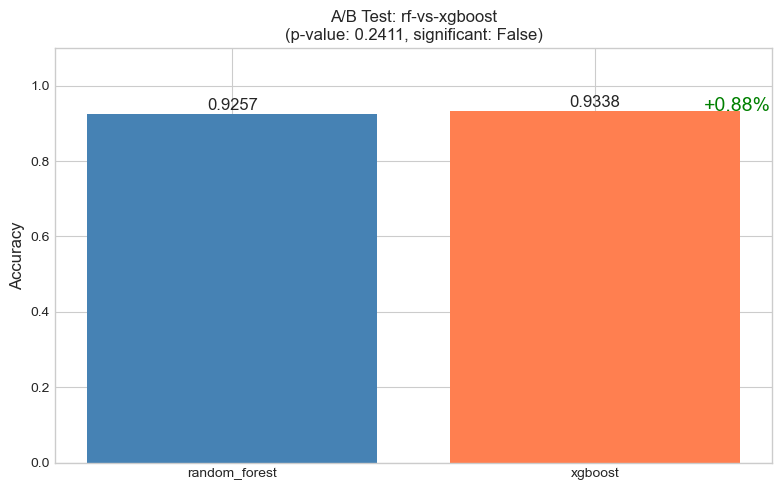

In [13]:
# Visualize A/B test result
fig, ax = plt.subplots(figsize=(8, 5))

variants = [ab_result.control_variant, ab_result.treatment_variant]
accuracies = [ab_result.control_value, ab_result.treatment_value]
colors = ["steelblue", "coral"]

bars = ax.bar(variants, accuracies, color=colors)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{acc:.4f}", ha="center", fontsize=12)

ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title(f"A/B Test: {ab_result.test_name}\n"
             f"(p-value: {ab_result.p_value:.4f}, "
             f"significant: {ab_result.is_significant})", fontsize=12)
ax.set_ylim(0, 1.1)

# Add improvement annotation
ax.annotate(
    f"{ab_result.relative_improvement:+.2%}",
    xy=(1, ab_result.treatment_value),
    xytext=(1.3, ab_result.treatment_value),
    fontsize=14,
    color="green" if ab_result.relative_improvement > 0 else "red",
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "ab_test_result.png", dpi=150, bbox_inches="tight")
plt.show()

In [14]:
# Interactive A/B test simulation
ab_test = ABTest("simulated-test", confidence_level=0.95)
ab_test.add_variant("control", rf_model, traffic_weight=0.5)
ab_test.add_variant("treatment", xgb_model, traffic_weight=0.5)
ab_test.start()

# Simulate traffic (using test data)
n_simulate = min(500, len(X_test))
for i in range(n_simulate):
    sample_id = f"user_{i}"
    variant, pred = ab_test.predict(X_test[i:i+1], sample_id=sample_id)
    ab_test.record_outcome(sample_id, y_test[i])

# Analyze
simulated_result = ab_test.analyze(metric="accuracy", control="control")
print("\nSimulated A/B Test:")
print(simulated_result)


Simulated A/B Test:
A/B Test Results: simulated-test
Metric: accuracy
Control (control): 0.9715
Treatment (treatment): 0.9409
Relative Improvement: -3.15%
P-value: 0.1471
Statistically Significant (95%): NO
Sample sizes: {'control': 246, 'treatment': 254}


In [15]:
# Test summary
summary = ab_test.get_summary()
print("\nTest Summary:")
print(f"  Status: {summary['status']}")
print(f"  Variants:")
for name, data in summary['variants'].items():
    print(f"    {name}: {data['n_predictions']} predictions")


Test Summary:
  Status: running
  Variants:
    control: 246 predictions
    treatment: 254 predictions


## 5. MLflow UI

To view the MLflow UI, run in terminal:
```bash
cd fittrack-ml
mlflow ui --backend-store-uri mlruns
```

Then open http://localhost:5000 in your browser.

## 6. Summary

### MLOps Best Practices Demonstrated:

1. **Experiment Tracking** (MLflow)
   - Log parameters, metrics, and models
   - Compare runs and find best performers
   - Reproducibility through logged artifacts

2. **Model Registry**
   - Version control for models
   - Lifecycle stages (Staging → Production)
   - Easy model loading for deployment

3. **A/B Testing**
   - Statistical significance testing
   - Sample size calculation
   - Traffic splitting strategies

### Production Checklist:
- [ ] Set up remote MLflow tracking server
- [ ] Configure model registry backend (PostgreSQL, MySQL)
- [ ] Implement model serving infrastructure
- [ ] Set up monitoring and alerting
- [ ] Automate model retraining pipeline